# Notebook for dimensionality reduction & clustering of RNA-seq data in transcripts per million

Collaborators: 
* Vrishabhadev Sathish Kumar
* PI: Erin Wilson

Data files:
* RNA-seq output from barrelseq pipeline
* mapping from sample id to experiment condition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import math
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# load TPM data
tpm_data_file = 'data/TPM_counts.tsv'
sample2condition_file = 'data/sample2condition.txt'

# load TPM data
df = pd.read_csv(tpm_data_file,sep='\t').fillna('')

    
# load mapping from sample to condition
with open(sample2condition_file,'r') as f:
    sample2condition = dict(x.strip().split() for x in f.readlines())
    

In [3]:
conditions = set(sample2condition.values())
conditions

{'LanzaTech',
 'MeOH',
 'NO3_lowO2_slow_growth',
 'NoCu',
 'NoLanthanum',
 'WT_control',
 'WithLanthanum',
 'aa3_KO',
 'crotonic_acid',
 'highCu',
 'highO2_slow_growth',
 'lowCH4',
 'lowCu',
 'lowO2_fast_growth',
 'lowO2_slow_growth',
 'medCu',
 'slow_growth',
 'uMax',
 'unknown'}

***
# Navigation:

### [Dimensionality Reduction](#dim_red)

### [Clustering](#clustering)

***


<a id = "dim_red"></a>

# Dimensionality Reduction

## Strategy: 

Use PCA to plot all the samples relative to each other in 2D space. Color the points by their experimental condition.

* Are there any points that don’t co-locate with others supposedly in its same category together well?
* Try with raw TPM values and standard scaler values
    * Try after filtering out genes that don’t express very highly
    * 0.0 in all conditions?
< 10 tpm in all conditions?
Only the top 10% in all conditions?
Aka If a gene is in the top 10% of genes in any of the conditions, keep it in the analysis. Else filter it out

Repeat 1 but try a different dimensionality reduction method - tSNE, UMAP

## Local Navigation
### [Functions](#func)
### [PCA](#pca)
#### [raw tpm values](#pca_raw)
#### [scaled tpm values](#pca_scaled)
### [UMAP](#umap)
#### [raw tpm values](#umap_raw)
#### [scaled tpm values](#umap_scaled)
### [tSNE](#tsne)
#### [raw tpm values](#tsne_raw)
#### [scaled tpm values](#tsne_scaled)

***
<a id = "func"></a>

# Plotting Functions

## Seaborn Scatter

In [4]:
# Plot each of the samples in the reduced two dimensions
# --> Note that they have been colored by their sample's experimental condition

def seaborn_scatter(data, title, color_sort):
    plt.figure(figsize=(8,8))
    sns.scatterplot("PC1", "PC2", data = data, hue= color_sort, s = 50)

    # Put the legend out of the figure
    plt.legend(bbox_to_anchor=(1.05, 1), loc = 2, borderaxespad=0.)

    plt.title(title)

## Altair Interactive Scatter

#### FUNCTION NOT DISPLAYING GRAPHS WHEN CALLED

In [5]:
# Interactive Altair Plot that allows for tool-tip details for each data point
# and allows for the filtering of the data shown by clicking on the legend
# --> tooltips = [tooltip_sample, color_sort]
def altair_scatter(data, title, color_sort, tooltips):
    # Filtering Mechanism (for the legend)
    selection = alt.selection_multi(fields=[color_sort])

    # Color change based on the selection field picked above
    color = alt.condition(selection,
                          alt.Color(color_sort + ':N', legend=None),
                          alt.value('lightgray'))

    scatter = alt.Chart(df_dim_reduced_raw).mark_point(size=200).encode(
        x='PC1',
        y='PC2',
        tooltip= tooltips,
        color=color
    ).properties(
        width =800, 
        height = 600
    ).interactive()

    legend = alt.Chart(df_dim_reduced_raw).mark_point(size = 150).encode(
        y=alt.Y(color_sort, axis=alt.Axis(orient='right')),
        color=color
    ).add_selection(
        selection
    )
    
    return scatter | legend 

## Explained Variance Plots

In [6]:
def plot_pca_var(pca, 
                 title="Variance explained by PCA components", tag = None):
    
    # title tag
    if tag:
        title = title + " (%s)"%tag
        
    # plot cumulative variance across components
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(title)
    plt.show()
    
    # plot individual explained variances for each component
    plt.bar(range(len(pca.explained_variance_ratio_)), 
            pca.explained_variance_ratio_,
            label="individual explained variance")
    
    plt.step(range(len(pca.explained_variance_ratio_)), 
             np.cumsum(pca.explained_variance_ratio_),
             label="cumulative explained variance",
             c='red')
    
    plt.xlabel('Number of Components')
    plt.ylabel("Explained Variance")
    plt.title(title)
    plt.legend(loc='best')
    plt.show()
    

***
<a id = "pca"></a>

## PCA - Principal Component Analysis


In [70]:
# Mission: Reorganize dataset into 98x4213 dataframe where
#     --> columns represent each locus
#     --> rows represent each sample present

# GOAL: reduce the dimensions of this dataframe so that we can represent each sample with just two dimensions

df_raw_tpm = df.iloc[:, 10:].T
loci = df["locus_tag"]
df_raw_tpm = df_raw_tpm.set_axis(loci, axis = 1)

df_raw_tpm 

locus_tag,EQU24_RS00005,EQU24_RS00010,EQU24_RS00015,EQU24_RS00020,EQU24_RS00025,EQU24_RS00030,EQU24_RS00035,EQU24_RS00040,EQU24_RS00045,EQU24_RS00050,...,EQU24_RS22110,EQU24_RS22115,EQU24_RS22120,EQU24_RS22125,EQU24_RS22130,EQU24_RS22135,EQU24_RS22140,EQU24_RS22145,EQU24_RS22150,EQU24_RS22155
5GB1_ferm_Ack_QC_tpm,2.933003,1.607784,1.415515,3.200081,1.522728,2.013385,8.890269,1.632474,0.790911,0.446398,...,170.826337,0.973237,2.344352,2.331287,4.867523,2.300157,5.261582,9.389775,21.657488,27.832080
5GB1_ferm_WT_QC_tpm,6.033848,3.895284,2.549771,4.301580,3.797084,1.694449,9.506517,3.340407,2.160868,1.134421,...,259.349616,2.866741,1.856930,0.951269,3.972334,3.217944,12.526353,21.072962,42.254357,41.530602
5GB1_FM03_TR1_QC_tpm,48.864921,51.315629,33.906257,64.584281,74.801354,13.090237,50.320911,20.811187,21.910217,18.096708,...,6655.778183,56.948463,52.002311,60.628466,23.015801,104.488835,379.686212,500.129230,1191.565348,796.964423
5GB1_FM03_TR2_QC_tpm,52.197450,54.947425,29.979783,72.717824,62.709260,24.874673,71.255094,19.773190,19.421485,16.776993,...,6480.237054,50.243190,41.376658,66.581832,54.669612,103.864151,401.742811,495.262554,1232.784967,724.291958
5GB1_FM11_TR1_QC_tpm,25.751902,37.216017,21.716802,53.032824,46.348014,42.426259,58.772307,9.667881,8.212313,12.634273,...,6651.883413,25.635202,29.059082,59.545627,34.189659,78.264069,208.094267,260.011454,666.589153,461.697526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5GB1C-5G-N-BR2_tpm,33.432274,48.142385,22.006566,64.648318,39.358066,34.654512,107.541275,33.869275,23.770815,20.064562,...,9003.930101,20.600870,37.114422,39.499880,42.467068,30.766617,166.101675,59.523445,259.828426,404.714461
5GB1C-JG15-La-BR1_tpm,39.880174,45.465136,22.658157,69.119079,38.992158,67.033753,130.729298,39.968258,22.454067,18.039069,...,3318.767885,10.724405,39.422680,49.109710,46.810258,22.101468,96.169044,47.641158,134.795621,265.487592
5GB1C-JG15-La-BR2_tpm,38.355431,46.498139,22.753325,65.643179,35.870964,51.959561,120.575354,37.092594,20.769383,17.655632,...,3458.558649,15.496249,41.910716,53.086286,44.827579,19.753259,93.527806,60.667488,160.260255,308.428817
5GB1C-JG15-N-BR1_tpm,30.247582,37.152951,19.407103,57.590223,41.462392,44.527488,105.320613,27.798238,18.873435,15.578396,...,3997.726513,17.356475,41.685308,44.836637,47.307203,20.027390,89.780995,55.739018,174.197473,286.670085


In [58]:
# Learned from videos: 
#     - https://www.youtube.com/watch?v=QdBy02ExhGI
#     - https://www.youtube.com/watch?v=FgakZw6K1QQ&t=26s

from sklearn.decomposition import PCA

pca = PCA()
pca_3d = PCA(n_components = 3)


<a id = "pca_raw"></a>
### Raw TPM Values 

In [55]:
# Use PCA library in sklearn to fit and transform desired raw tpm data for each sample 
dim_reduced_raw = pca_3d.fit_transform(df_raw_tpm)


# create dataframe with array + keep track of conditions so that its easy to grab the colors for plotting
df_dim_reduced_raw = pd.DataFrame(dim_reduced_raw)
df_dim_reduced_raw = df_dim_reduced_raw.set_axis(["PC1", "PC2", "PC3"], axis = 1)
df_dim_reduced_raw['sample_name'] = df_raw_tpm.index
df_dim_reduced_raw['condition'] = df_dim_reduced_raw['sample_name'].apply(lambda x: sample2condition[x])

df_dim_reduced_raw

,PC1,PC2,PC3,sample_name,condition
0,422873.717192,255313.543634,-4939.014196,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth
1,398643.480798,144239.681457,13780.401924,5GB1_ferm_WT_QC_tpm,lowO2_slow_growth
2,-12218.522022,13369.821351,-1910.308393,5GB1_FM03_TR1_QC_tpm,uMax
3,-12084.997507,29992.143969,-6261.496683,5GB1_FM03_TR2_QC_tpm,uMax
4,56359.572873,-35975.642510,-4219.526257,5GB1_FM11_TR1_QC_tpm,lowO2_fast_growth
...,...,...,...,...,...
93,-95021.849393,18222.230539,-30191.344829,5GB1C-5G-N-BR2_tpm,NoLanthanum
94,-62342.074140,-13581.299560,-20896.979314,5GB1C-JG15-La-BR1_tpm,WithLanthanum
95,-59037.755783,-18448.391664,-20329.023038,5GB1C-JG15-La-BR2_tpm,WithLanthanum
96,-55126.823217,-11343.400952,-23227.186120,5GB1C-JG15-N-BR1_tpm,NoLanthanum


/home/skvdev17/anaconda3/envs/sandbox/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


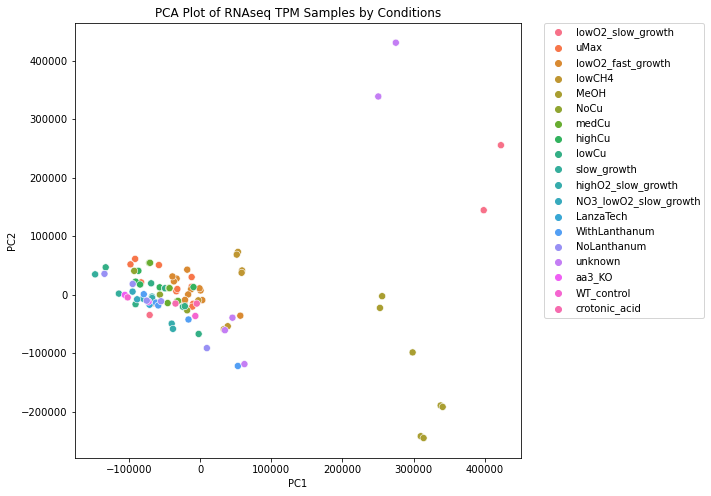

In [59]:
# Plot each of the raw PCA samples in the reduced two dimensions
# --> Note that they have been colored by their sample's experimental condition

title = "PCA Plot of RNAseq TPM Samples by Conditions"
seaborn_scatter(df_dim_reduced_raw, title,"condition")

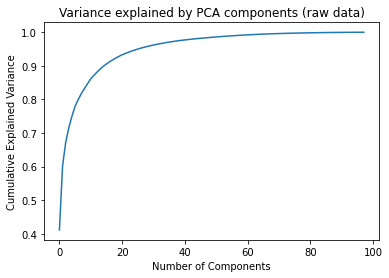

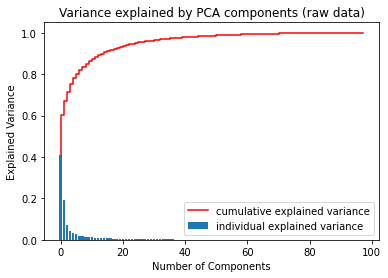

In [53]:
# draw basic matplotlib plots of variance explained and projections
pca_explained = PCA()
pca_explained.fit_transform(df_raw_tpm)
plot_pca_var(pca, tag = "raw data")

In [ ]:
# 3D attempt at PCA Visualization 
# thoughts: not as informative as initially expected. 

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection = "3d")

x = df_dim_reduced_raw["PC1"]
y = df_dim_reduced_raw["PC2"]
z = df_dim_reduced_raw["PC3"]

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

ax.scatter(x, y, z)

plt.show()

In [ ]:
# Interactive Altair Plot that allows for tool-tip details for each data point
# and allows for the filtering of the data shown by clicking on the legend

# Parameters: 
data = df_dim_reduced_raw
title = "Interactive PCA Plot of RNAseq TPM Samples by Condition"
color_sort = "condition"
tooltips = ['sample_name', 'condition']

# Function Call <-- ** not working yet **
chart = altair_scatter(data, title, color_sort, tooltips)
chart
# # Filtering Mechanism (for the legend)
# selection = alt.selection_multi(fields=[color_sort])

# # Color change based on the selection field picked above
# color = alt.condition(selection,
#                       alt.Color(color_sort + ':N', legend=None),
#                       alt.value('lightgray'))

# scatter = alt.Chart(data, title = title).mark_point(size=200).encode(
#     x='PC1',
#     y='PC2',
#     tooltip= tooltips,
#     color=color
# ).properties(
#     width =800, 
#     height = 600
# ).interactive()

# legend = alt.Chart(df_dim_reduced_raw).mark_point(size = 150).encode(
#     y=alt.Y(color_sort, axis=alt.Axis(orient='right')),
#     color=color
# ).add_selection(
#     selection
# )

# scatter | legend 


<a id = "pca_scaled"></a>
### Standard Scaled TPM Values 

In [60]:
from sklearn.preprocessing import StandardScaler

scaling = StandardScaler()

# Scale the raw TPM values
table_standard_scaled = scaling.fit_transform(df_raw_tpm)
df_standard_scaled = pd.DataFrame(table_standard_scaled, index=df_raw_tpm.index, columns=df_raw_tpm.columns)
df_standard_scaled

locus_tag,EQU24_RS00005,EQU24_RS00010,EQU24_RS00015,EQU24_RS00020,EQU24_RS00025,EQU24_RS00030,EQU24_RS00035,EQU24_RS00040,EQU24_RS00045,EQU24_RS00050,...,EQU24_RS22110,EQU24_RS22115,EQU24_RS22120,EQU24_RS22125,EQU24_RS22130,EQU24_RS22135,EQU24_RS22140,EQU24_RS22145,EQU24_RS22150,EQU24_RS22155
5GB1_ferm_Ack_QC_tpm,-2.603133,-2.259301,-2.549015,-2.740799,-2.353692,-2.078703,-2.383537,-1.794759,-1.753345,-2.404526,...,-2.179663,-1.934566,-2.580757,-2.144403,-1.651152,-2.073446,-2.009289,-1.930047,-1.831182,-1.592541
5GB1_ferm_WT_QC_tpm,-2.371200,-2.150415,-2.426682,-2.682821,-2.216549,-2.102867,-2.361073,-1.666039,-1.638297,-2.314284,...,-2.148412,-1.805599,-2.626183,-2.238030,-1.707862,-2.038855,-1.950282,-1.843655,-1.780275,-1.566294
5GB1_FM03_TR1_QC_tpm,0.832428,0.106807,0.955226,0.490198,2.064990,-1.239475,-0.873275,-0.349337,0.020236,-0.089475,...,0.109707,1.877930,2.047180,1.810750,-0.501466,1.778033,1.031958,1.698744,1.060382,-0.118844
5GB1_FM03_TR2_QC_tpm,1.081690,0.279681,0.531742,0.918313,1.335840,-0.346638,-0.110167,-0.427566,-0.188766,-0.262572,...,0.047736,1.421231,1.056909,2.214655,1.503791,1.754488,1.211111,1.662757,1.162262,-0.258088
5GB1_FM11_TR1_QC_tpm,-0.896352,-0.564339,-0.359450,-0.117820,0.349261,0.983142,-0.565199,-1.189163,-1.130102,-0.805940,...,0.108332,-0.254830,-0.091043,1.737285,0.206394,0.789624,-0.361790,-0.076816,-0.237158,-0.761233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5GB1C-5G-N-BR2_tpm,-0.321885,-0.044241,-0.328198,0.493569,-0.072231,0.394322,1.212565,0.634799,0.176487,0.168632,...,0.938671,-0.597720,0.659684,0.377288,0.730765,-1.000549,-0.702873,-1.559332,-1.242515,-0.870415
5GB1C-JG15-La-BR1_tpm,0.160397,-0.171678,-0.257921,0.728890,-0.094295,2.847506,2.057832,1.094454,0.065908,-0.097036,...,-1.068351,-1.270410,0.874805,1.029264,1.005904,-1.327137,-1.270898,-1.647196,-1.551548,-1.137181
5GB1C-JG15-La-BR2_tpm,0.046351,-0.122507,-0.247657,0.545934,-0.282502,1.705424,1.687693,0.877727,-0.075571,-0.147328,...,-1.019001,-0.945398,1.106681,1.299054,0.880302,-1.415641,-1.292351,-1.550872,-1.488609,-1.054903
5GB1C-JG15-N-BR1_tpm,-0.560090,-0.567341,-0.608559,0.122062,0.054659,1.142339,1.131616,0.177249,-0.234791,-0.419782,...,-0.828660,-0.818697,1.085674,0.739359,1.037386,-1.405309,-1.322784,-1.587316,-1.454162,-1.096594


In [65]:
pca = PCA()

# Use PCA library in sklearn to fit and transform desired raw tpm data for each sample 
dim_reduced_scaled = pca_3d.fit_transform(df_standard_scaled)

# create dataframe with array + keep track of conditions so that its easy to grab the colors for plotting
df_dim_reduced_scaled = pd.DataFrame(dim_reduced_scaled)

df_dim_reduced_scaled = df_dim_reduced_scaled.set_axis(["PC1", "PC2", "PC3"], axis = 1)

# Make new columns to keep track of additional information
df_dim_reduced_scaled['sample_name'] = df_standard_scaled.index
df_dim_reduced_scaled['condition'] = df_dim_reduced_scaled['sample_name'].apply(lambda x: sample2condition[x])

df_dim_reduced_scaled

,PC1,PC2,PC3,sample_name,condition
0,133.327259,31.868564,-12.302832,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth
1,128.569868,31.277452,-12.013723,5GB1_ferm_WT_QC_tpm,lowO2_slow_growth
2,-0.709897,-24.016274,-0.301526,5GB1_FM03_TR1_QC_tpm,uMax
3,-4.019517,-24.062205,-0.030573,5GB1_FM03_TR2_QC_tpm,uMax
4,22.450584,-1.407047,-0.356053,5GB1_FM11_TR1_QC_tpm,lowO2_fast_growth
...,...,...,...,...,...
93,-52.456471,37.561239,18.727650,5GB1C-5G-N-BR2_tpm,NoLanthanum
94,-74.414391,82.348965,17.458037,5GB1C-JG15-La-BR1_tpm,WithLanthanum
95,-77.947430,78.728240,20.008664,5GB1C-JG15-La-BR2_tpm,WithLanthanum
96,-68.138698,69.335626,22.428426,5GB1C-JG15-N-BR1_tpm,NoLanthanum


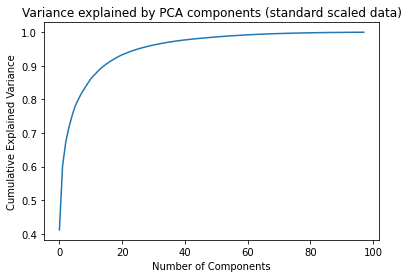

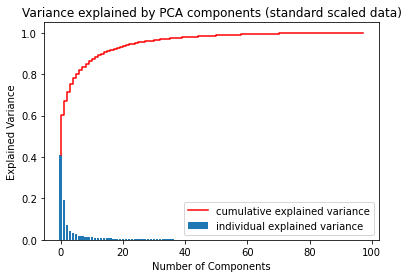

In [66]:
# draw basic matplotlib plots of variance explained and projections
pca = PCA()
pca.fit_transform(df_standard_scaled)
plot_pca_var(pca, tag = "standard scaled data")

/home/skvdev17/anaconda3/envs/sandbox/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


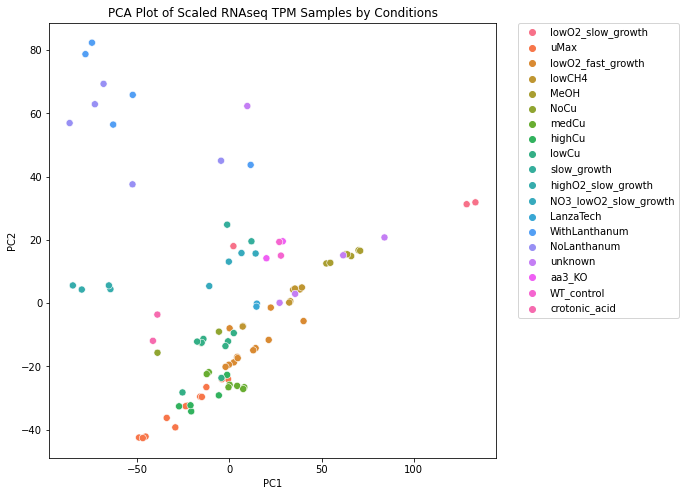

In [67]:
# Plot each of the SCALED PCA samples in the reduced two dimensions
# --> Note that they have been colored by their sample's experimental condition

title = "PCA Plot of Scaled RNAseq TPM Samples by Conditions"
seaborn_scatter(df_dim_reduced_scaled, title,"condition")

In [69]:
# Interactive Altair Plot that allows for tool-tip details for each data point
# and allows for the filtering of the data shown by clicking on the legend
# for SCALED tpm data

# Parameters: 
data = df_dim_reduced_scaled
title = "Interactive PCA Plot of Scaled RNAseq TPM Samples by Condition"
color_sort = "condition"
tooltips = ['sample_name', 'condition']

# Function Call <-- ** not working yet **
altair_scatter(data, title, color_sort, tooltips)

alt.HConcatChart(...)

### UMAP Method

### tSNE Method

***
<a id = "clustering"></a>

# Clustering

### Determine if the computer-generated clustering reveals outliers
- Notably, check if the outlier samples detected in the correlation analysis are apparent through this method!

<h4>k-means clustering</h4>

<h4>k-NN</h4>

<h4>DBSCAN</h4>